In [1]:
import tensorflow as tf
import keras 
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.layers.normalization import BatchNormalization 
from keras import backend as K
from keras.layers import GaussianNoise, advanced_activations
from keras.engine.topology import Layer
from keras.legacy import interfaces
from keras.initializers import Zeros as kZeros
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
import sklearn
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook, tnrange
from time import time

Using TensorFlow backend.


### Function Definitions

#### Most Likely Symbol Layer
I have intially done this with a normal function, however this hasn't been working with Keras. What I'm probably going to do next is make a custom layer for this as well and then add this. <br>
Not sure whether to use this in training though as using softwax may be a good way of training the model to give decisive decisions and it's also pretty useful for seeing the probabilities, and therefore confidence in it's decisions.

Numpy function

In [2]:
def most_likely_symbol(posterior_probs):
    row_indices = np.arange(posterior_probs.shape[0])
    col_indices = np.argmax(posterior_probs, axis=1)
    ret_arr = np.zeros(posterior_probs.shape)
    ret_arr[row_indices,col_indices] = 1
    return ret_arr

Keras backend (tensorflow) function

In [3]:
def most_likely(posterior_probs):
    max_vals = K.max(posterior_probs, axis=1, keepdims=True) 
    max_vals = K.cast(max_vals, 'float32')
    geT = K.greater_equal(posterior_probs, max_vals)
    return K.cast(geT, 'float32')

#### Custom most likely symbol layer
This layer need to, for all in-phase and quaternary outputs, pick the most likely symbol. <br>
I need to take in a softmax probability distribution for all the possible symbols (One hot encoded) and pick the one with the maximum likelyhood (value). Say $M$=2, then $S$ = {01,10} so $\hat{S}$ = {01,10}. This layer converts something that looks something like [0.63,0.27] to [1,0] <br>
**Note:** This layer should only be used in testing because gradients do not propogate through round functions. So this is a layer that should only be used at test time. 

In [4]:
class MostLikelySymbol(Layer):
    """Return the most likely symbol from a softmax input in the
    one hot encoded form.

    This layer is only active at test time as otherwise it would
    stop gradient propogation during training. Also it is useful
    to train with a softmax output to encourage a decisive 
    decision and because it means you can assess confidence.

    # Arguments
        None

    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.

    # Output shape
        Same shape as input.
    """

    @interfaces.legacy_gaussiannoise_support
    def __init__(self, **kwargs):
        super(MostLikelySymbol, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs, training=None):
        def most_likely():
            max_vals = K.max(inputs, axis=1, keepdims=True) 
            max_vals = K.cast(max_vals, 'float32')
            geT = K.greater_equal(inputs, max_vals)
            return K.cast(geT, 'float32')            
        return K.in_train_phase(inputs, most_likely, training=training)

    def get_config(self):
        config = {}
        base_config = super(MostLikelySymbol, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

#### Custom GaussianNoise layer
Ok, so the problem with the built in GaussianNoise layer is that it only adds noise at training time and not at testing time. So I've had a look in the source code and found how this is enacted. <br>
I'm now going to define my own custom layer which does exactly the same thing, but just adds the noise at both training time and testing time. <br>
I'm going to copy the source code from keras then just fiddle it so it does what I want.

In [5]:
class GaussianNoise2(Layer):
    """Apply additive zero-centered Gaussian noise at both traning
    and test time.

    This is useful to mitigate overfitting
    (you could see it as a form of random data augmentation).
    Gaussian Noise (GS) is a natural choice as corruption process
    for real valued inputs.

    Unlike the built in GaussianNoise regularisation layer it is 
    active at both training and test time. 

    # Arguments
        stddev: float, standard deviation of the noise distribution.

    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.

    # Output shape
        Same shape as input.
    """

    @interfaces.legacy_gaussiannoise_support
    def __init__(self, stddev, **kwargs):
        super(GaussianNoise2, self).__init__(**kwargs)
        self.supports_masking = True
        self.stddev = stddev

    def call(self, inputs, training=None):
        def noised():
            return inputs + K.random_normal(shape=K.shape(inputs),
                                            mean=0.,
                                            stddev=self.stddev)
        return K.in_train_phase(noised, noised, training=training)

    def get_config(self):
        config = {'stddev': self.stddev}
        base_config = super(GaussianNoise2, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [6]:
def make_model(M, R, sigma, activation_func):
    ### Initialising Parameters
    k = np.log2(M) # Number of bits needed to represent M 
                   # messages
    Nc = int(round(k/R)) # Number of bit being used to represent
                        # channel symbols being used 
                        # Number of complex channel uses
    Nr = Nc*2 # Number of real channel uses

    ### Defining Layers
    ## TRANSMITTER
    # This is my input placeholder
    input_message = Input(shape=(M,), name="input")
    # Encoded representation of the input
    # Relu layer to capture non-linearity
    tx1 = Dense(Nr,activation=activation_func, name="tx1")\
                (input_message)
    # Linear layer to give channel symbols not
    # clustered around 0 and 1.
    tx2 = Dense(Nr,activation=activation_func, name="tx2")(tx1)
    # Reshape it to complex channel symbols
    tx_complex = Lambda(lambda x : K.reshape(x, (-1,Nc,2)),
                       output_shape=(Nc,2), \
                        name="tx_reshape")(tx2)

    # Normalisation Layer
    tx_norm = Lambda(lambda x : K.l2_normalize(x,axis=2),
                     output_shape=(Nc,2), name="tx_norm")\
                        (tx_complex)
#     tx_norm = BatchNormalization(axis=2)(tx_complex)

    # Add Noise 
    noise = GaussianNoise2(sigma)(tx_norm)

    ## RECIEVER
    # Flatten the input
    noise_flat = Lambda(lambda x : K.reshape(x, (-1,Nr)),
                       output_shape=(Nr,),\
                        name="noise_flat")(noise)
    # Multiple Dense Layers
    # Dense relu layer to capture non linearity
    rx1 = Dense(M,activation=activation_func, name="rx1")\
                (noise_flat)
    # Dense layer with softmax activation
    rx_softmax = Dense(M,activation='softmax', \
                       name="rx_softmax")(rx1)
    # Select the symbols with the maximum probabilities
    ml_symbs = MostLikelySymbol()(rx_softmax)
    
    ###Defining the models
    autoencoder = Model(input_message, rx_softmax)
    ## Model the Tx and Rx seperately as well
    # Model the Tx
    transmitter = Model(input_message, tx_norm)
    # Model the Tx plus the noise
    channel_sym_with_noise = Model(input_message, noise)
    channel_symbol = Input(shape=(Nc,2))
    # Take the last layer of the autoencoder model
    reciever_layers = autoencoder.layers[-2](channel_symbol)
    reciever_layers = autoencoder.layers[-1](reciever_layers)

    # Create a model of the reciever
    reciever = Model(channel_symbol, reciever_layers)
    autoencoder_symbs = Model(input_message,ml_symbs) 
    
    # Compile the model
    autoencoder.compile(loss='categorical_crossentropy',
                    optimizer="adam")
    return autoencoder, transmitter, reciever, autoencoder_symbs, k, Nc, Nr

In [7]:
def plot_constellation_diagram(valid_set, transmitter, name):
    channel_symbols = transmitter.predict(valid_set)
    fig, ax = plt.subplots()
    ax.plot(channel_symbols[:,:,0], channel_symbols[:,:,1],\
            'k.')
    ax.set_title("CS Constellation Diagram: "+name)
    ax.set_aspect('equal', 'box')
#     ax.axis([-2, 2, -2, 2])
#     ax.tick_params(axis='both', length=1., width=1.)
    plt.xticks([-2,-1,0,1,2])
    plt.yticks([-2,-1,0,1,2])
    plt.grid(True)
#     # set the x-spine (see below for more info on `set_position`)
#     ax.spines['left'].set_position('zero')
#     # turn off the right spine/ticks
#     ax.spines['right'].set_color('none')
#     ax.yaxis.tick_left()
#     # set the y-spine
#     ax.spines['bottom'].set_position('zero')
#     # turn off the top spine/ticks
#     ax.spines['top'].set_color('none')
#     ax.xaxis.tick_bottom()

In [8]:
def get_block_error_rate(test_data, pred_symbs):
    errors = (test_data != pred_symbs)
    block_errors = errors.any(axis=1)
    return block_errors.sum()/block_errors.shape[0]

In [9]:
def get_noise_sigma(Eb_N0_db, R):
    Eb_N0 = 10.**(Eb_N0_db/10.)
    return np.sqrt(1./(2.*R*Eb_N0))

In [10]:
def get_data_set(M, total_size):
    t0 = time()
    all_one_hot_messages = np.diag(np.ones(M))
    perc_train = 0.75
    perc_valid = 0.1

    ## Making Data Set
    multiple = total_size//M
    diff = total_size - (multiple * M)

    ## Get quotient 
    ## Converted the array into a list because it is significantly
    ## faster
    l = []
    all_one_hot_messages_lst = all_one_hot_messages.tolist()
    for mult in range(multiple):
        for i in range(M):
            l.append([all_one_hot_messages_lst[i]])
    data = np.concatenate(l)

    # Add remainder
    random_inds = np.random.choice(np.arange(M),size=diff, replace=False)
    extra_rows = all_one_hot_messages[random_inds,:]
    data = np.concatenate((data, extra_rows), axis=0)
    np.random.shuffle(data)
    file_path = "./data/data"+str(M)+".npy"
    np.save(file_path, data)
    print(f"Took {time() - t0}s")
    return data, file_path, all_one_hot_messages

#### BKSP functions

In [11]:
def bpsk_encode(int_bit):
    if(int_bit == 0):
        return -1
    elif(int_bit == 1):
        return 1
    else:
        assert(False)
bpsk_encode_vec = np.vectorize(bpsk_encode)

In [12]:
def bpsk_decode(float_bit):
    if(float_bit <= 0.):
        return 0
    elif(float_bit >0.):
        return 1
    else:
        assert(False)
bpsk_decode_vec = np.vectorize(bpsk_decode)

#### Hamming 7,4 functions

In [13]:
# Essential matrices for Hamming encoding
G = np.array(\
             [[1,1,0,1],
             [1,0,1,1],
             [1,0,0,0],
             [0,1,1,1],
             [0,1,0,0],
             [0,0,1,0],
             [0,0,0,1]])
H = np.array(\
            [[1,0,1,0,1,0,1],
            [0,1,1,0,0,1,1],
            [0,0,0,1,1,1,1]])
p = np.array([[1],
             [0],
             [1],
             [1]])
R_ham = np.array([[0,0,1,0,0,0,0],
                 [0,0,0,0,1,0,0],
                 [0,0,0,0,0,1,0],
                 [0,0,0,0,0,0,1]])

In [14]:
def make_lsb(dec_num):
    return float(int(bin(int(dec_num))[-1]))
# vectorising the function made it about 40% faster,
# not incredible but makes a small difference
make_lsb_vec = np.vectorize(make_lsb)

In [15]:
def get_error_ind(arr_col):
    return 4*arr_col[0] + 2*arr_col[1] + arr_col[2] - 1

In [16]:
def do_error_correction(data, error_inds):
    for i in range(data.shape[1]):
        if(error_inds[i] >= 0):
            data[int(error_inds[i]),i] = float(np.logical_not(data[int(error_inds[i]),i]))

In [17]:
def hamming_7_4_encode(test_data, G):
    test_data_enc = np.matmul(G,test_data.T)
    return make_lsb_vec(test_data_enc)   

In [18]:
def hamming_7_4_decode_and_correct(received, H, R):
    # Round values to [0,1]
    r_round = np.where(received > 0.5, 1, 0)
    # Do parity check
    parity_check = np.matmul(H,r_round)
    parity_check = make_lsb_vec(parity_check)   
    # Get error bit indices
    error_inds = np.apply_along_axis(get_error_ind, 0,\
                                     parity_check)
    # Do error correction
    do_error_correction(r_round, error_inds)
    # Decode corrected message
    return np.matmul(R,r_round).T

### To do list
- DONE/Work out how to add noise even at test time
- DONE/Make most likely symbol layer
- DONE/Turn all the inputs and outputs into complex numbers 
- DONE/Fix the normalisation layer, currently for M=2 and N=1 I'm just getting 0 and 1, whereas you'd expect -c and +c. Note this needs to take into account the IQ pairs.
- DONE/Make BPSK encoding
- DONE/Make Hamming encoding 
- DONE/Get a graph comparing Hamming encoding, BPSK and an autoencoder
- Sweep across different activation functions to see what error and constellation diagrams they get.
- Sweep across different batch sizes to see what gives a better model
- Sweep across different training noise_stds to find the best for training
- Graph didn't look great to try out a (7,4) autoencoder
- Implement t-SNE so I can get constellation diagrams for the cases with n>2.


#### Work Log
06/02/2019
- Changed the normalisation to use the BatchNormalization function <br>

07/02/2019
- Changed the batch size, increased the data size and changed the axis along which BatchRegularization was done
- The results were very inconsistent, reading suggested this might be to do with the ReLu activation function giving dependence on initialisation values due to neuron death.
- Consequently tried a leaky-relu activation function
- Found a bug that one layer was being bypassed
- Switched back to original regularisation layer but over a different axis.
- Decided it makes sense to use an l2 regulariser as that reflects a transmitter with a constant power budget
- Named all layers so that weights could be loaded from one layer into another
- Plotted BLER graph for (2,2) case
- Started implementing hamming encoding

08/02/2019
- Changed the constellation diagram plot to match the O'Shea paper's format.

13/02/2019
- Added hard decision Hamming encoding and decoding
- Added BPSK encoding and decoding
- Compared Autoencoder (2,2), BPSK (4,4) and Hamming (7,4) hard decision one one graph


In [19]:
## Overall layout
# Take a message of M symbols (2^k)
# Start with one-hot encoded symbols beign passed into
# the NN
# Convert it into n bits for channel transmission
# Add noise
# Convert back into a posterior probability vector
# Select max


In [20]:
#def Transmitter
# One hot encoded layer
# Multiple dense layers
# Normalisation layer
# return x

### IQ complex number general notes
The symbols at each end are not in IQ form, but the channel symbols need to be in IQ form. <br>
Potentially I could do this purely by increasing the number of nodes in the middle. But I'm not sure how I specify the pair relationships.<br>
Currently reading about this in EE3-03 Communication System, Lecutre 2.d "Constellation Diagram & Line Codes...", slide 15.

### Chat with M.Varasteh
- first consider without dropout
- try out different activation functions 
- try out different numbers of layers
- Try out using different activation functions for two halfs of a given layer. This is called Inception networks. 
- You can't do this with standard code out of tf and keras, will have to write custom code.
- Tanh is usually good because it is linear for small inputs, relu is better for capturing non-linearity 
- Inception learning allows the optimisation to pick the activation function
- Can have a custom activation function which picks is a weighted sum of say relu and tanh.


### Hyperparameters I should look at
- Activation functions:
    - Tanh - ~linear for small inputs 
    - Relu - captures non linearity well
    - Sigmoid, softmax, linear
    - Inception learning
- Loss functions
    - MSE, categorical cross entropy
- Regularisation
    - Dropout
    - Normalisation constraints:
        - $\lVert x\rVert _2^2 \leq n$, $\lvert x_i \rvert \leq 1$, $E[\lvert x_i\rvert ^2] \lt 1$
- Structure
    - Try making it 2d in the first layer vs in the last layer
    - Number of layers

### Noise Ideas
- In O'Shea et al they used AWGN with variance = (2*R*E_b/N_0)^-1
Later I'd like to try
    - Slow and Fast Rayleigh fading 
    - Try all the types of stuff found in the textbook

In [21]:
#def Noise Layer
# Add noise, probably start with AWGN
# Later try
# - Slow and Fast Rayleigh fading 
# - Try all the types of stuff found in the textbook
# x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 

In [22]:
#def Reciever
# Multiple dense layers
# Dense layer with softmax activation
# This gives an array of posterior probabilities, so then
# pick the maximum of these posterior probabilities.

## Getting started
- Start with M = 2 (k = 1), n = 1 (so R = 1), try and learn BPSK
- Let's learn it, have a look at the constellation diagram, then try some bigger M's

Testing the two most_likely_symbol functions

In [23]:
pps2 = np.random.rand(5,3)
totals = np.expand_dims(np.sum(pps2, axis=1), axis=1)
pps2 = np.divide(pps2,totals)
pps2 = np.round(pps2,2)
ppsT = K.constant(pps2)
sess = tf.Session()
with sess.as_default():
    ppsT.eval(session=sess)
ppsT.eval(session=sess)

array([[0.36, 0.46, 0.19],
       [0.6 , 0.17, 0.23],
       [0.5 , 0.33, 0.17],
       [0.29, 0.39, 0.32],
       [0.34, 0.55, 0.11]], dtype=float32)

In [24]:
most_likely(ppsT).eval(session=sess)

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [25]:
most_likely_symbol(pps2)

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

### Making a model
I'm thinking that to express every input as a complex number (in-phase and quaterature) parts, I could run two NN's in parallel, but then it wouldn't be able to learn any links between ther two. <br>
Alternatively make it twice as wide, so each input goes in in pairs, and select the most likely symbols from even indices and odd indices seperately, output of that is my complex output.

The O'Shea paper trained their models $E_b/N_o = 7db$, so the training variance is calculated below using the formula from the paper

In [26]:
M = 4 # Number of one hot encoded messages
R = 2 # R = k/n

sigma = get_noise_sigma(7, R)
print("sigma = ",sigma)
autoencoder4, transmitter4, reciever4, autoencoder_symbs4, k4, Nc4, Nr4 = make_model(M, R, sigma, "relu")

sigma =  0.22334179607548157


In [81]:
M = 4 # Number of one hot encoded messages
R = 2 # R = k/n

sigma = get_noise_sigma(7, R)
print("sigma = ",sigma)
autoencoder4adam, transmitter4adam, reciever4adam, autoencoder_symbs4adam, k4, Nc4, Nr4 = make_model(M, R, sigma, "relu")

sigma =  0.22334179607548157


In [38]:
M = 16 # Number of one hot encoded messages
R = 4 # R = k/n

sigma = get_noise_sigma(7, R)
print("sigma = ",sigma)
autoencoder16, transmitter16, reciever16, autoencoder_symbs16, k16, Nc16, Nr16 = make_model(M, R, sigma, "relu")

sigma =  0.15792649852735607


### Make a toy data set

In [29]:
# # Get a set of data for a particular M
# all_one_hot_messages = np.diag(np.ones(M))
# print("all_one_hot_messages.shape = ",all_one_hot_messages.shape)
# #total_size = 10,000,000 (10M)
# total_size = 10000000

# # Automatically saves the data for m to a filepath of
# # './data/data${M}.npy'
# func_data4, file_path4, all_one_hot_messages4 = get_data_set(4, total_size)
# func_data16, file_path16, all_one_hot_messages16 = get_data_set(16, total_size)

# # Don't use this function unless it's for a new M, just
# # load the data you have calculated other times.
# # This makes results more comparible and saves time.

all_one_hot_messages.shape =  (4, 4)
Took 34.2166953086853s
Took 39.254642963409424s


In [27]:
# Load the data calculated from previsou runs
data16 = np.load('./data/data16.npy')
data4 = np.load('./data/data4.npy')

In [28]:
# Splitting into training, testing and validation sets
train_data4, test_data4 = train_test_split(data4, \
                                         train_size=0.8)
train_data4, valid_data4 = train_test_split(train_data4, \
                                         train_size=0.9)
print(f"train_data4.shape = {train_data4.shape}")
print(f"valid_data4.shape = {valid_data4.shape}")
print(f"test_data4.shape = {test_data4.shape}")

/home/apsw/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


train_data4.shape = (7200000, 4)
valid_data4.shape = (800000, 4)
test_data4.shape = (2000000, 4)


In [29]:
# Splitting into training, testing and validation sets
train_data16, test_data16 = train_test_split(data16, \
                                         train_size=0.8)
train_data16, valid_data16 = train_test_split(train_data16, \
                                         train_size=0.9)
print(f"train_data16.shape = {train_data16.shape}")
print(f"valid_data16.shape = {valid_data16.shape}")
print(f"test_data16.shape = {test_data16.shape}")

train_data16.shape = (7200000, 16)
valid_data16.shape = (800000, 16)
test_data16.shape = (2000000, 16)


### Fit model

In [77]:
autoencoder4.fit(train_data4, train_data4,
                epochs=80,
                batch_size=1000*M,
                shuffle=True,
                validation_data=(valid_data4,
                                 valid_data4))

Train on 7200000 samples, validate on 800000 samples
Epoch 1/80
7200000/7200000 [==============================] - 20s 3us/step - loss: 0.0788 - val_loss: 0.0679
Epoch 2/80
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.0777 - val_loss: 0.2856
Epoch 3/80
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.0771 - val_loss: 0.0805
Epoch 4/80
7200000/7200000 [==============================] - 13s 2us/step - loss: 0.0765 - val_loss: 0.0666
Epoch 5/80
7200000/7200000 [==============================] - 26s 4us/step - loss: 0.0778 - val_loss: 0.0670
Epoch 6/80
7200000/7200000 [==============================] - 13s 2us/step - loss: 0.0751 - val_loss: 0.0656
Epoch 7/80
7200000/7200000 [==============================] - 12s 2us/step - loss: 0.0754 - val_loss: 0.0666
Epoch 8/80
7200000/7200000 [==============================] - 12s 2us/step - loss: 0.0755 - val_loss: 0.0643
Epoch 9/80
7200000/7200000 [==============================] - 15s 2us/step 

7200000/7200000 [==============================] - 28s 4us/step - loss: 0.0674 - val_loss: 0.0611
Epoch 76/80
7200000/7200000 [==============================] - 26s 4us/step - loss: 0.0665 - val_loss: 0.0630
Epoch 77/80
7200000/7200000 [==============================] - 28s 4us/step - loss: 0.0678 - val_loss: 0.0626
Epoch 78/80
7200000/7200000 [==============================] - 24s 3us/step - loss: 0.0682 - val_loss: 0.0635
Epoch 79/80
7200000/7200000 [==============================] - 60s 8us/step - loss: 0.0678 - val_loss: 0.0696
Epoch 80/80
7200000/7200000 [==============================] - 32s 4us/step - loss: 0.0670 - val_loss: 0.0633


In [82]:
autoencoder4adam.fit(train_data4, train_data4,
                epochs=10,
                batch_size=1000*M,
                shuffle=True,
                validation_data=(valid_data4,
                                 valid_data4))

Train on 7200000 samples, validate on 800000 samples
Epoch 1/10
7200000/7200000 [==============================] - 18s 3us/step - loss: 0.5851 - val_loss: 0.3601
Epoch 2/10
7200000/7200000 [==============================] - 19s 3us/step - loss: 0.3531 - val_loss: 0.3503
Epoch 3/10
7200000/7200000 [==============================] - 17s 2us/step - loss: 0.3488 - val_loss: 0.3485
Epoch 4/10
7200000/7200000 [==============================] - 17s 2us/step - loss: 0.3477 - val_loss: 0.3479
Epoch 5/10
7200000/7200000 [==============================] - 15s 2us/step - loss: 0.3473 - val_loss: 0.3476
Epoch 6/10
7200000/7200000 [==============================] - 13s 2us/step - loss: 0.3471 - val_loss: 0.3475
Epoch 7/10
7200000/7200000 [==============================] - 13s 2us/step - loss: 0.3470 - val_loss: 0.3474
Epoch 8/10
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.3469 - val_loss: 0.3473
Epoch 9/10
7200000/7200000 [==============================] - 13s 2us/step 

In [63]:
autoencoder16.fit(train_data16, train_data16,
                epochs=100,
                batch_size=1000*M,
                shuffle=True,
                validation_data=(valid_data16,
                                 valid_data16))

Train on 7200000 samples, validate on 800000 samples
Epoch 1/100
7200000/7200000 [==============================] - 24s 3us/step - loss: 2.7802 - val_loss: 2.7734
Epoch 2/100
7200000/7200000 [==============================] - 26s 4us/step - loss: 2.7733 - val_loss: 2.7733
Epoch 3/100
7200000/7200000 [==============================] - 26s 4us/step - loss: 2.7733 - val_loss: 2.7732
Epoch 4/100
7200000/7200000 [==============================] - 34s 5us/step - loss: 2.7732 - val_loss: 2.7731
Epoch 5/100
7200000/7200000 [==============================] - 33s 5us/step - loss: 2.7731 - val_loss: 2.7731
Epoch 6/100
7200000/7200000 [==============================] - 18s 2us/step - loss: 2.7731 - val_loss: 2.7731
Epoch 7/100
7200000/7200000 [==============================] - 18s 3us/step - loss: 2.7730 - val_loss: 2.7730
Epoch 8/100
7200000/7200000 [==============================] - 19s 3us/step - loss: 2.7730 - val_loss: 2.7730
Epoch 9/100
7200000/7200000 [==============================] - 21s 

KeyboardInterrupt: 

### Save Model

In [158]:
# autoencoder4_2.save('./models/autoencoder4_2.model')
# autoencoder4_2.save_weights('./models/autoencoder4_2.h5')

In [175]:
# autoencoder2.save('second_qpsk_model.model')
# autoencoder2.save_weights('second_qpsk_model.h5')

In [ ]:
autoencoder.save('16_qam_model.model')
autoencoder.save_weights('16_qam_model.h5')

### Load Model

In [176]:
## QPSK
# autoencoder_loaded, transmitter_loaded, reciever_loaded, autoencoder_symbs_loaded, k, Nc, Nr = make_model(4, 2, sigma, "relu")
# # autoencoder_loaded = load_model('first_qpsk_model.model')
# autoencoder_loaded.load_weights('second_qpsk_model.h5', by_name=True)

In [ ]:
## 16-QAM
autoencoder_loaded, transmitter_loaded, reciever_loaded, autoencoder_symbs_loaded, k, Nc, Nr = make_model(4, 2, sigma, "relu")
# autoencoder_loaded = load_model('first_qpsk_model.model')
autoencoder_loaded.load_weights('second_qpsk_model.h5', by_name=True)

In [171]:
# Autoencoder2
# 10 epochs, sigma = 7, M=4,Nc=1
# Batch size = 1000*M (=4)
autoencoder.predict(all_one_hot_messages)

array([[9.9887031e-01, 9.5893274e-04, 1.7014996e-04, 5.6230721e-07],
       [3.5033667e-05, 9.9901247e-01, 7.8783961e-07, 9.5165835e-04],
       [2.6391426e-02, 4.8780008e-03, 9.5980561e-01, 8.9249481e-03],
       [1.1229349e-05, 7.4189520e-03, 6.3138956e-04, 9.9193841e-01]],
      dtype=float32)

In [64]:
# Autoencoder2
# 10 epochs, sigma = 7, M=4,Nc=1
# Batch size = 1000*M (=4)
autoencoder4.predict(all_one_hot_messages4)

array([[0.24977851, 0.2497287 , 0.25057766, 0.24991512],
       [0.24977851, 0.2497287 , 0.25057766, 0.24991512],
       [0.24977851, 0.2497287 , 0.25057766, 0.24991512],
       [0.24977851, 0.2497287 , 0.25057766, 0.24991512]], dtype=float32)

In [71]:
# Autoencoder2
# 10 epochs, sigma = 7, M=4,Nc=1
# Batch size = 1000*M (=4)
autoencoder4.predict(all_one_hot_messages4)

array([[8.3998597e-01, 1.5999793e-01, 1.0808836e-05, 5.2908149e-06],
       [4.5145387e-03, 9.9430746e-01, 1.1549346e-03, 2.2973401e-05],
       [1.7289858e-07, 1.3793851e-03, 9.9029678e-01, 8.3236368e-03],
       [1.9964839e-06, 1.6661914e-04, 8.7676076e-03, 9.9106383e-01]],
      dtype=float32)

In [83]:
# Autoencoder4adam
# 10 epochs, sigma = 7, M=4,Nc=1
# Batch size = 1000*M (=4)
autoencoder4.predict(all_one_hot_messages4)

array([[9.9996293e-01, 3.7083475e-05, 5.5497373e-10, 1.2034070e-08],
       [1.2867179e-05, 9.4511670e-01, 5.4866053e-02, 4.4076314e-06],
       [4.2827363e-08, 3.5511691e-03, 9.9640983e-01, 3.8957834e-05],
       [2.1591043e-07, 4.1583294e-06, 8.3846896e-04, 9.9915719e-01]],
      dtype=float32)

#### 16-QAM

In [262]:
# Autoencoder16
# 10 epochs, sigma = 7, M=16,Nc=1
# Batch size = M (=4)
autoencoder16.predict(all_one_hot_messages16)

array([[0.06307946, 0.0603232 , 0.06303293, 0.06182882, 0.06222745,
        0.06192977, 0.06223914, 0.06284608, 0.06305691, 0.06201155,
        0.06539723, 0.06244788, 0.0630474 , 0.06390437, 0.06036985,
        0.0622579 ],
       [0.06234477, 0.06197815, 0.06240558, 0.06180114, 0.0617576 ,
        0.06300463, 0.06242082, 0.06190391, 0.06230155, 0.06214499,
        0.06355254, 0.06309292, 0.06336578, 0.06381183, 0.0614631 ,
        0.06265078],
       [0.05969861, 0.06443395, 0.06151018, 0.06410369, 0.06506898,
        0.06411163, 0.06442393, 0.06636913, 0.06101652, 0.0635223 ,
        0.06287112, 0.05960989, 0.05871293, 0.05891304, 0.06405944,
        0.06157465],
       [0.06355537, 0.06153271, 0.06345335, 0.06128814, 0.0618329 ,
        0.06237773, 0.06194945, 0.06068011, 0.0632104 , 0.06194219,
        0.06153139, 0.06339206, 0.06356515, 0.06425428, 0.06218991,
        0.06324475],
       [0.06234208, 0.0608103 , 0.06191898, 0.06280486, 0.0620039 ,
        0.06200742, 0.06282803, 

In [ ]:
# Autoencoder16
# 100 epochs, sigma = 7, M=16,Nc=1
# Batch size = M (=4)
autoencoder16.predict(all_one_hot_messages16)

#### Changing batch size

### Look at the channel symbols

Ideally for channel symbols I want to plot the in phase and quaternary symbols as my x and y axis

#### Complex channel symbols

In [52]:
f"M={M}, Nc={Nc}, Nr={Nr}"

'M=4, Nc=1, Nr=2'

#### Shape of the channel symbols section
It is currently (M,Nc,2), but it should either be (M,2) or (Nc,2), I don't really get how the n comes into it. I think normally n is the number of bits you'd be allowed to transmit with, so n bits allows $2^n$ different complex channel symbols. But I can have continuous values. So what is the point of the the n. <br>
Potentially what I need to do is to reduce the channel symbol layer to only (1,2), then it will have to find continuous values using only two dimensions, which is kind of what I want as I only have two different axes. <br>
Alternatively I could make R the ratio between the k and the number of real bits used as opposed to the number of complex bits used.

### Weird encoding
For some reason it's never using the 11 option. Only 00, 01 and 10. I don't know why this is but I supect it's something to do with the regularisation.<br>
Because of the regularisation I'd expect it to be able to give cc instead of 11, where $c=\sqrt{2}$

### QPSK Constellation Diagrams
#### Autoencoder2 (changed back to l2_normalise)
axis = 2, 10 epochs

In [172]:
print(f"M={M},Nc={Nc},Nr={Nr}")
print(transmitter2.predict(all_one_hot_messages).shape)
#(M,Nc,2)
transmitter2.predict(all_one_hot_messages)

M=4,Nc=1,Nr=2
(4, 1, 2)


array([[[-0.9896787 ,  0.14330396]],

       [[ 0.9832694 , -0.18215774]],

       [[-0.16840957, -0.98571706]],

       [[ 0.12707114,  0.9918936 ]]], dtype=float32)

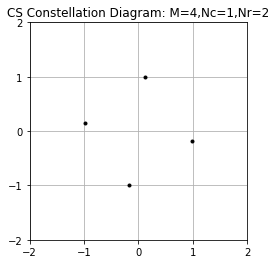

In [240]:
plot_constellation_diagram(all_one_hot_messages, transmitter2, f"M={M},Nc={Nc},Nr={Nr}")
# plt.savefig("./figures/qpsk_constellation_diagram.png")

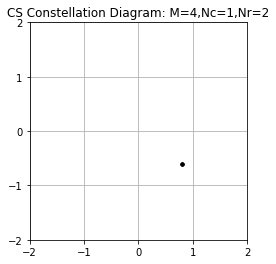

In [68]:
plot_constellation_diagram(all_one_hot_messages4, transmitter4, f"M={M},Nc={Nc4},Nr={Nr4}")
# plt.savefig("./figures/qpsk_constellation_diagram.png")

#### Autoencoder4 trained from fresh2
axis = 2, 10 epochs

In [72]:
print(f"M={M},Nc={Nc4},Nr={Nr4}")
print(transmitter4.predict(all_one_hot_messages4).shape)
#(M,Nc,2)
transmitter4.predict(all_one_hot_messages4)

M=4,Nc=1,Nr=2
(4, 1, 2)


array([[[-0.8381607 ,  0.5454234 ]],

       [[-0.0331063 ,  0.9994519 ]],

       [[ 0.83851695,  0.54487556]],

       [[ 0.9236054 , -0.3833446 ]]], dtype=float32)

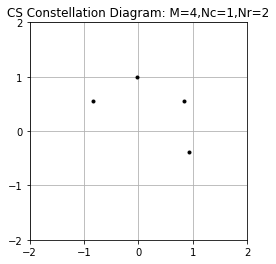

In [73]:
plot_constellation_diagram(all_one_hot_messages4, transmitter4, f"M={M},Nc={Nc4},Nr={Nr4}")
# plt.savefig("./figures/qpsk_constellation_diagram.png")

#### Autoencoder4 trained from fresh2
Same as above, but trained for 10 epochs (an extra 10)

In [75]:
print(f"M={M},Nc={Nc4},Nr={Nr4}")
print(transmitter4.predict(all_one_hot_messages4).shape)
#(M,Nc,2)
transmitter4.predict(all_one_hot_messages4)

M=4,Nc=1,Nr=2
(4, 1, 2)


array([[[-0.83112544,  0.556085  ]],

       [[ 0.02088728,  0.9997818 ]],

       [[ 0.785271  ,  0.61915225]],

       [[ 0.92870617, -0.37081653]]], dtype=float32)

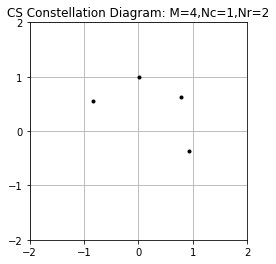

In [76]:
plot_constellation_diagram(all_one_hot_messages4, transmitter4, f"M={M},Nc={Nc4},Nr={Nr4}")
# plt.savefig("./figures/qpsk_constellation_diagram.png")

#### Autoencoder4 trained from fresh3
Same as above, but trained for 100 epochs (an extra 80)

In [78]:
print(f"M={M},Nc={Nc4},Nr={Nr4}")
print(transmitter4.predict(all_one_hot_messages4).shape)
#(M,Nc,2)
transmitter4.predict(all_one_hot_messages4)

M=4,Nc=1,Nr=2
(4, 1, 2)


array([[[-0.81807053,  0.5751178 ]],

       [[ 0.05629861,  0.998414  ]],

       [[ 0.87932265,  0.47622645]],

       [[ 0.88242936, -0.47044495]]], dtype=float32)

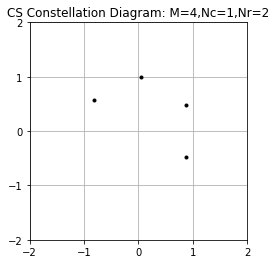

In [79]:
plot_constellation_diagram(all_one_hot_messages4, transmitter4, f"M={M},Nc={Nc4},Nr={Nr4}")
# plt.savefig("./figures/qpsk_constellation_diagram.png")

#### Autoencoder4adam
Trained over 10 epochs using an Adam optimiser as used in the paper

In [86]:
print(f"M={M},Nc={Nc4},Nr={Nr4}")
print(transmitter4adam.predict(all_one_hot_messages4).shape)
#(M,Nc,2)
transmitter4adam.predict(all_one_hot_messages4)

M=4,Nc=1,Nr=2
(4, 1, 2)


array([[[-0.99388415, -0.11042722]],

       [[ 0.45482168,  0.89058256]],

       [[ 0.6019942 , -0.79850054]],

       [[-0.99388415, -0.11042722]]], dtype=float32)

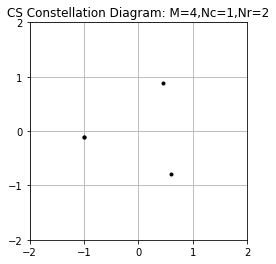

In [87]:
plot_constellation_diagram(all_one_hot_messages4, transmitter4adam, f"M={M},Nc={Nc4},Nr={Nr4}")
# plt.savefig("./figures/qpsk_constellation_diagram.png")

#### New training set, 1 epochs

In [71]:
print(f"M={M},Nc={Nc},Nr={Nr}")
print(transmitter.predict(all_one_hot_messages).shape)
#(M,Nc,2)
transmitter.predict(all_one_hot_messages)

M=4,Nc=1,Nr=2
(4, 1, 2)


array([[[ 0.08172178, -2.2294135 ]],

       [[-4.237483  , -3.2946773 ]],

       [[ 1.7539062 ,  2.044017  ]],

       [[-1.433624  ,  1.4104607 ]]], dtype=float32)

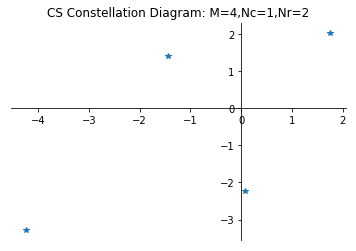

In [72]:
plot_constellation_diagram(all_one_hot_messages, f"M={M},Nc={Nc},Nr={Nr}")
# plt.savefig("./figures/wrong_constellation_diagram.png")

### 16-QAM Constellation Diagrams
#### Autoencoder16
10 epochs

In [263]:
print(f"M={M},Nc={Nc},Nr={Nr}")
print(transmitter16.predict(all_one_hot_messages16).shape)
#(M,Nc,2)
transmitter16.predict(all_one_hot_messages16)

M=16,Nc=1,Nr=2
(16, 1, 2)


array([[[-0.8166406 ,  0.5771466 ]],

       [[-0.8171146 ,  0.5764752 ]],

       [[-0.81698024,  0.57666564]],

       [[-0.81669366,  0.5770714 ]],

       [[-0.8170382 ,  0.5765834 ]],

       [[-0.81692266,  0.57674736]],

       [[-0.81657773,  0.57723564]],

       [[-0.8168798 ,  0.5768078 ]],

       [[-0.81660795,  0.5771928 ]],

       [[-0.81739414,  0.5760787 ]],

       [[-0.81669426,  0.57707053]],

       [[-0.8165637 ,  0.5772553 ]],

       [[-0.81745994,  0.5759855 ]],

       [[-0.8167853 ,  0.5769417 ]],

       [[-0.8165637 ,  0.5772553 ]],

       [[-0.8165637 ,  0.5772553 ]]], dtype=float32)

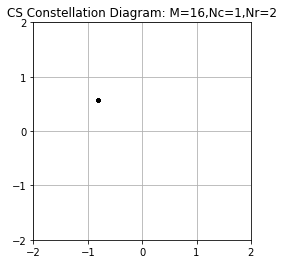

In [264]:
plot_constellation_diagram(all_one_hot_messages16, transmitter16, f"M={M},Nc={Nc},Nr={Nr}")
# plt.savefig("./figures/qpsk_constellation_diagram.png")

#### Autoencoder16
24 epochs, validation loss converged to 2.7728 and stopped decreasing. Interestingly the points are not exactly the same as they were when the QPSK case had inputs mapping to the same channel symbol

In [266]:
print(f"M={M},Nc={Nc},Nr={Nr}")
print(transmitter16.predict(all_one_hot_messages16).shape)
#(M,Nc,2)
transmitter16.predict(all_one_hot_messages16)

M=16,Nc=1,Nr=2
(16, 1, 2)


array([[[-0.816641  ,  0.577146  ]],

       [[-0.8171153 ,  0.57647425]],

       [[-0.81697845,  0.5766682 ]],

       [[-0.8166949 ,  0.5770695 ]],

       [[-0.81704015,  0.57658076]],

       [[-0.81692564,  0.5767431 ]],

       [[-0.8165782 ,  0.57723486]],

       [[-0.81688267,  0.5768038 ]],

       [[-0.81660825,  0.5771923 ]],

       [[-0.81739527,  0.57607704]],

       [[-0.81669563,  0.5770686 ]],

       [[-0.8165637 ,  0.5772553 ]],

       [[-0.8174593 ,  0.5759863 ]],

       [[-0.8167832 ,  0.57694477]],

       [[-0.8165637 ,  0.5772553 ]],

       [[-0.8165637 ,  0.5772553 ]]], dtype=float32)

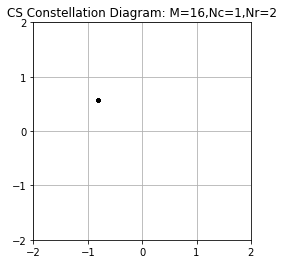

In [267]:
plot_constellation_diagram(all_one_hot_messages16, transmitter16, f"M={M},Nc={Nc},Nr={Nr}")
# plt.savefig("./figures/qpsk_constellation_diagram.png")

### Look at the output

In [313]:
all_one_hot_messages

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [312]:
autoencoder.predict(all_one_hot_messages)

array([[0.8531254 , 0.14687462],
       [0.09675152, 0.9032485 ],
       [0.8531254 , 0.14687456],
       [0.09675154, 0.9032485 ]], dtype=float32)

In [314]:
autoencoder_symbs.predict(all_one_hot_messages)

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

#### Complex

In [33]:
autoencoder.predict(all_one_hot_messages)

array([[0.8915605 , 0.10843948],
       [0.16489638, 0.8351037 ],
       [0.8915604 , 0.10843955],
       [0.16489628, 0.83510375]], dtype=float32)

In [34]:
autoencoder_symbs.predict(all_one_hot_messages)

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

### Assess performance across a range of SNRs
The O'Shea paper defined the variance of the noise to be $β = (2RE_b/N_0)^{−1}$

In [204]:
t0 = time()
Eb_N0_dbs = np.arange(-4,8.5,0.5)
bler = np.empty(Eb_N0_dbs.size)
for i, ratio_db in enumerate(tqdm_notebook(Eb_N0_dbs, desc="1st loop")):
    print(f"ratio_db = {ratio_db}, i = {i}/{Eb_N0_dbs.size}", end="\r")
    ## Get noise std_dev 
    noise_std = get_noise_sigma(ratio_db, R)
    ## Make new model with loaded weights
    autoencoder_loaded, transmitter_loaded, \
        reciever_loaded, autoencoder_symbs_loaded, \
        k_l, Nc_l, Nr_l \
        = make_model(M, R, noise_std, "relu")
    autoencoder_loaded.load_weights('second_qpsk_model.h5', by_name=True)
        
    ## Check Accuracy on test set
    pred_symbs = autoencoder_symbs_loaded.predict(test_data)
    bler[i] = get_block_error_rate(test_data, pred_symbs)
print(f"Took {time() - t0}")

Took 2131.674866437912/25


### Plot results

In [243]:
# ## Save
# autoencoder_2_2_bler = bler
# np.save('./key_results/autoencoder_2_2_bler.npy', autoencoder_2_2_bler)
# ## Load
# autoencoder_2_2_bler = np.load('./key_results/autoencoder_2_2_bler.npy')

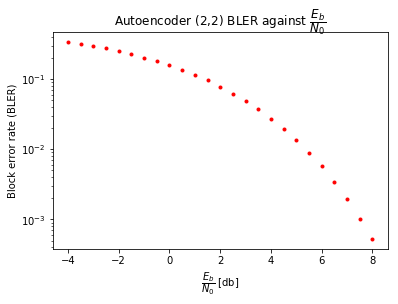

In [221]:
plt.semilogy(Eb_N0_dbs, bler, 'r.')
plt.title(r'Autoencoder (2,2) BLER against $\dfrac{E_b}{N_0}$')
plt.xlabel(r'$\dfrac{E_b}{N_0}$ [db]')
plt.ylabel("Block error rate (BLER)")
# plt.savefig("./figures/autoencoder_2_2_bler_EbNo.png")

### Implementing Uncoded BPSK

 would be good to use this in the presentation
 https://en.wikipedia.org/wiki/Phase-shift_keying

In [157]:
std = 0.22
test_data_bpsk = test_data4
bpsk_encoded = bpsk_encode_vec(test_data_bpsk)
# Add AWGN noise
noise = std * np.random.randn(test_data_bpsk.shape[0],\
                              test_data_bpsk.shape[1])
received = test_data_bpsk + noise
bpsk_decoded = bpsk_decode_vec(received)

# Get Block error rate
bler = get_block_error_rate(test_data4, bpsk_decoded)
all_true = (bpsk_decoded == test_data4).all()
print("bler = ", bler)
print("all_true = ", all_true)

bler =  0.8748135
all_true =  False


In [ ]:
t0 = time()
Eb_N0_dbs = np.arange(-4,8.5,0.5)
bler_bpsk = np.empty(Eb_N0_dbs.size)
for i, ratio_db in enumerate(tqdm_notebook(Eb_N0_dbs, desc="1st loop")):
    print(f"ratio_db = {ratio_db}, i = {i}/{Eb_N0_dbs.size}")
    ## Get noise std_dev 
    noise_std = get_noise_sigma(ratio_db, R)
    # Encode using BPSK
    test_data_bpsk = test_data4
    bpsk_encoded = bpsk_encode_vec(test_data_bpsk)
    # Add AWGN noise
    noise = noise_std * np.random.randn(bpsk_encoded.shape[0],\
                                        bpsk_encoded.shape[1])
    received = bpsk_encoded + noise
    # Decode using BPSK
    bpsk_decoded = bpsk_decode_vec(received)
    # Check Accuracy on test set
    bler_bpsk[i] = get_block_error_rate(test_data4, bpsk_decoded)
print(f"Took {time() - t0}")

In [208]:
# ## Save
# bpsk_4_4_bler = bler_bpsk
# np.save('./key_results/bpsk_4_4_bler.npy', bpsk_4_4_bler)
# ## Load
bpsk_4_4_bler = np.load('./key_results/bpsk_4_4_bler.npy')

Text(0, 0.5, 'Block error rate (BLER)')

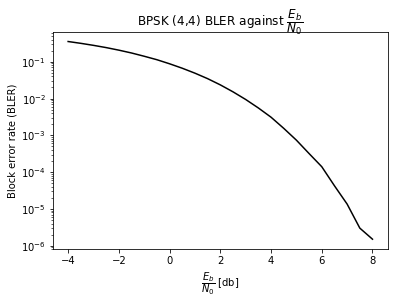

In [232]:
plt.semilogy(Eb_N0_dbs, bler_bpsk, 'k-')
plt.title(r'BPSK (4,4) BLER against $\dfrac{E_b}{N_0}$')
plt.xlabel(r'$\dfrac{E_b}{N_0}$ [db]')
plt.ylabel("Block error rate (BLER)")
# plt.savefig("./figures/autoencoder_2_2_bler_EbNo.png")

### Implementing Hamming Encoded BPSK

In [133]:
std = 0.22
# Encode the one_hot_encoded_vectors into bits
test_data_enc = hamming_7_4_encode(test_data4, G)   
# add noise
noise = std * np.random.randn(test_data_enc.shape[0],\
                              test_data_enc.shape[1])
r = test_data_enc + noise
# Do error correction and decode message
corrected_message = hamming_7_4_decode_and_correct(r, H,\
                                                   R)
# Get Block error rate
bler = get_block_error_rate(test_data4, corrected_message)
all_true = (corrected_message == test_data4).all()
print("bler = ", bler)
print("all_true = ", all_true)

bler =  0.024232
all_true =  False


In [215]:
t0 = time()
# Eb_N0_dbs = np.arange(-4,-2,0.5)
Eb_N0_dbs = np.arange(-4,8.5,0.5)
bler_hamming_HD = np.empty(Eb_N0_dbs.size)
for i, ratio_db in enumerate(tqdm_notebook(Eb_N0_dbs, desc="1st loop")):
    print(f"ratio_db = {ratio_db}, i = {i}/{Eb_N0_dbs.size}", end="\r")
    ## Get noise std_dev 
    noise_std = get_noise_sigma(ratio_db, R)
    ## Transmit Hamming encoded and BPSK
    test_data_enc = hamming_7_4_encode(test_data4, G) 
    bpsk_encoded = bpsk_encode_vec(test_data_enc)
    # Add AWGN noise
    noise = noise_std * np.random.randn(bpsk_encoded.shape[0],\
                                        bpsk_encoded.shape[1])
    received = bpsk_encoded + noise
    # Decode using BPSK
    bpsk_decoded = bpsk_decode_vec(received)

    # Decode using BPSK
    corrected_message = hamming_7_4_decode_and_correct(bpsk_decoded, H,\
                                                       R_ham)
    # Check Accuracy on test set
    bler_hamming_HD[i] = get_block_error_rate(test_data4, corrected_message)
print(f"Took {time() - t0}")

Took 1624.589095592498825


In [218]:
# ## Save
# hamming_7_4_HD_bler = bler_hamming_HD
# np.save('./key_results/hamming_7_4_HD_bler.npy', hamming_7_4_HD_bler)
# ## Load
hamming_7_4_HD_bler = np.load('./key_results/hamming_7_4_HD_bler.npy')

Text(0, 0.5, 'Block error rate (BLER)')

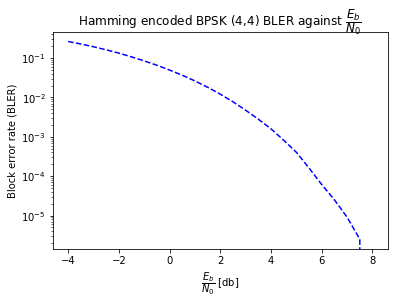

In [231]:
plt.semilogy(Eb_N0_dbs, bler_hamming_HD, 'b--')
plt.title(r'Hamming encoded BPSK (4,4) BLER against $\dfrac{E_b}{N_0}$')
plt.xlabel(r'$\dfrac{E_b}{N_0}$ [db]')
plt.ylabel("Block error rate (BLER)")
# plt.savefig("./figures/autoencoder_2_2_bler_EbNo.png")

### Hamming Encoding with Hard Decision

### Hamming Encoding with MLD

### Comparison of Hamming, BPSK and autoencoder systems

In [221]:
# Load three sets of results
bpsk_4_4_bler = np.load('./key_results/bpsk_4_4_bler.npy')
autoencoder_2_2_bler = np.load('./key_results/autoencoder_2_2_bler.npy')
hamming_7_4_HD_bler = np.load('./key_results/hamming_7_4_HD_bler.npy')

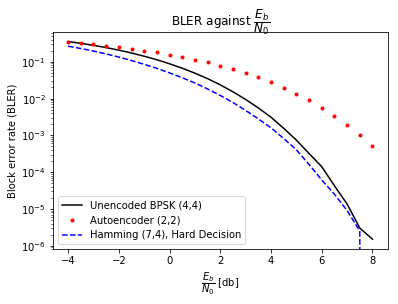

In [230]:
plt.semilogy(Eb_N0_dbs, bpsk_4_4_bler, 'k-')
plt.semilogy(Eb_N0_dbs, autoencoder_2_2_bler, 'r.')
plt.semilogy(Eb_N0_dbs, hamming_7_4_HD_bler, 'b--')
plt.title(r'BLER against $\dfrac{E_b}{N_0}$')
plt.xlabel(r'$\dfrac{E_b}{N_0}$ [db]')
plt.ylabel("Block error rate (BLER)")
plt.legend(['Unencoded BPSK (4,4)', 'Autoencoder (2,2)', 'Hamming (7,4), Hard Decision'], loc="lower left")
plt.savefig("./figures/bler_vs_eb_only_three.png")

## Sweeping across different activation functions

- Tanh - ~linear for small inputs
- Relu - captures non linearity well
- Sigmoid, softmax, linear
- Inception learning

In [ ]:
# M = 4 # Number of one hot encoded messages
# R = 2 # R = k/n

# sigma = get_noise_sigma(7, R)
# print("sigma = ",sigma)
# all_one_hot_messagesTmp = np.diag(np.ones(M))
# autoencoderTmp, transmitterTmp, recieverTmp, autoencoder_symbsTmp, kTmp, NcTmp, NrTmp = make_model(M, R, sigma, "relu")

# # Fit the model
# autoencoderTmp.fit(train_data4, train_data4,
#                 epochs=2,
#                 batch_size=1000*M,
#                 shuffle=True,
#                 validation_data=(valid_data4,
#                                  valid_data4))
# # Get the test BLER
# pred_symbs_tmp = autoencoder_symbsTmp.predict(test_data4)
# bler_tmp = get_block_error_rate(test_data4, pred_symbs_tmp)
# print("bler_tmp = ", bler_tmp)

In [34]:
# Initialise data structures
# activation_funcs = ["relu", "tanh", "sigmoid", "linear", "softmax"]
activation_funcs = ["softmax"]
# activation_func_sweep_results = {"relu":[], "tanh":[], "sigmoid":[], "linear": [], "softmax":[], "leakyrelu":[]}
activation_func_sweep_results = {"relu":[], "tanh":[], "sigmoid":[], "linear": [], 
                                 "softmax":[{},{},{},{},{},{},{},{}], "leakyrelu":[]}

# Initialise Variables
M = 4 # Number of one hot encoded messages
R = 2 # R = k/n
sigma = get_noise_sigma(7, R)
print("sigma = ",sigma)
all_one_hot_messagesTmp = np.diag(np.ones(M))

for act_f in activation_funcs:
    print("\n\nact_f = ", act_f)
#     for i in range(10):
    for i in range(8,10):
        print("\ni = ", i)
        
        if(act_f == "leaky_relu"):
            input_act = keras.layers.advanced_activations.LeakyReLU()
        else:
            input_act = act_f
        
        # Make a model
        autoencoderTmp, transmitterTmp, recieverTmp,\
            autoencoder_symbsTmp, kTmp, NcTmp, NrTmp \
            = make_model(M, R, sigma, input_act)
        
        # Fit the model
        autoencoderTmp.fit(train_data4, train_data4,
                        epochs=10,
                        batch_size=1000*M,
                        shuffle=True,
                        validation_data=(valid_data4,
                                         valid_data4))
        # Append a dictionary to the list for this activation 
        # function
        activation_func_sweep_results[act_f].append({})
        # Get the test BLER
        pred_symbs_tmp = autoencoder_symbsTmp.predict(test_data4)
        bler_tmp = get_block_error_rate(test_data4, pred_symbs_tmp) 
        activation_func_sweep_results[act_f][i]["bler"] = bler_tmp
        # Save the model
        activation_func_sweep_results[act_f][i]["model"] = {}
        activation_func_sweep_results[act_f][i]["model"]["autoencoder"] = autoencoderTmp
        activation_func_sweep_results[act_f][i]["model"]["transmitter"] = transmitterTmp
        activation_func_sweep_results[act_f][i]["model"]["autoencoder_symbs"] = autoencoder_symbsTmp
        # Save the constellation diagram
        const_diag = transmitterTmp.predict(all_one_hot_messagesTmp)
        activation_func_sweep_results[act_f][i]["const_diag"] = const_diag
        # Save the models
        auto_file_path = './models/activ_func_sweep/' + act_f + str(i) + "autoencoder"
        autoencoderTmp.save(auto_file_path+".model")
        autoencoderTmp.save_weights(auto_file_path+'.h5')
        
        tx_file_path = './models/activ_func_sweep/' + act_f + str(i) + "transmitter"
        transmitterTmp.save(tx_file_path+".model")
        transmitterTmp.save_weights(tx_file_path+'.h5')
        
        auto_symbs_file_path = './models/activ_func_sweep/' + act_f + str(i) + "autoencoder_symbs"
        autoencoder_symbsTmp.save(auto_symbs_file_path+".model")
        autoencoder_symbsTmp.save_weights(auto_symbs_file_path+'.h5')

sigma =  0.22334179607548157


act_f =  softmax

i =  8
Train on 7200000 samples, validate on 800000 samples
Epoch 1/10
7200000/7200000 [==============================] - 15s 2us/step - loss: 1.0325 - val_loss: 0.8655
Epoch 2/10
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.8462 - val_loss: 0.8370
Epoch 3/10
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.7324 - val_loss: 0.6409
Epoch 4/10
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.6119 - val_loss: 0.5896
Epoch 5/10
7200000/7200000 [==============================] - 17s 2us/step - loss: 0.5738 - val_loss: 0.5613
Epoch 6/10
7200000/7200000 [==============================] - 16s 2us/step - loss: 0.5514 - val_loss: 0.5436
Epoch 7/10
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.5377 - val_loss: 0.5336
Epoch 8/10
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.5249 - val_loss: 0.5016
Epoch 9/10
7200000/

### Get the data from the models saved

In [32]:
# Initialise data structures
# activation_funcs = ["relu", "tanh", "sigmoid", "linear", "softmax"]
activation_funcs = ["softmax"]
activation_func_sweep_results = {"relu":[], "tanh":[], "sigmoid":[], "linear": [], "softmax":[], "leakyrelu":[]}
af_blers = np.zeros((5,10))
af_const_diags = np.zeros((5,10,4,1,2))

# Initialise Variables
M = 4 # Number of one hot encoded messages
R = 2 # R = k/n
sigma = get_noise_sigma(7, R)
print("sigma = ",sigma)
all_one_hot_messagesTmp = np.diag(np.ones(M))

for j, act_f in enumerate(activation_funcs):
    print("\nact_f = ", act_f)
    #     for i in range(10):
    for i in range(8,10):
        print("i = ", i)
                
        # Load a model's autoencoder, transmitter and 
        # autoencoder_symbs
        auto_file_path = './models/activ_func_sweep/' + act_f + str(i) + "autoencoder"
        autoencoderTmp, transmitterTmp, recieverTmp, autoencoder_symbsTmp, kTmp, NcTmp, NrTmp = make_model(4, 2, sigma, act_f)
        # autoencoder_loaded = load_model('first_qpsk_model.model')
        autoencoderTmp.load_weights(auto_file_path+'.h5', by_name=True)
        
        # Append a dictionary to the list for this activation 
        # function
        activation_func_sweep_results[act_f].append({})
        # Get the test BLER
        pred_symbs_tmp = autoencoder_symbsTmp.predict(test_data4)
        bler_tmp = get_block_error_rate(test_data4, pred_symbs_tmp) 
        activation_func_sweep_results[act_f][i]["bler"] = bler_tmp
        af_blers[j,i] = bler_tmp
        
        # Save the constellation diagram
        const_diag = transmitterTmp.predict(all_one_hot_messagesTmp)
        activation_func_sweep_results[act_f][i]["const_diag"] = const_diag
        af_const_diags[j,i,:,:,:] = const_diag
        
        # Save the models in the dictionary
        activation_func_sweep_results[act_f][i]["model"] = {}
        activation_func_sweep_results[act_f][i]["model"]["autoencoder"] = autoencoderTmp
        activation_func_sweep_results[act_f][i]["model"]["transmitter"] = transmitterTmp
        activation_func_sweep_results[act_f][i]["model"]["autoencoder_symbs"] = autoencoder_symbsTmp

sigma =  0.22334179607548157

act_f =  softmax
i =  8


OSError: Unable to open file (unable to open file: name = './models/activ_func_sweep/softmax8autoencoder.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

#### Save the dictionary

In [ ]:
import pickle

pickle_out = open("./models/activ_func_sweep/activation_func_sweep_results.pickle","wb")
pickle.dump(activation_func_sweep_results, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("./models/activ_func_sweep/activation_func_sweep_results.pickle","rb")
example_dict2 = pickle.load(pickle_in)

In [ ]:
np.save('./key_results/af_blers.npy', af_blers)
np.save('./key_results/af_const_diags.npy', af_const_diags)

### Plot the test errors for the five activation functions

In [ ]:
af_blers = np.load('./key_results/af_blers.npy')
af_const_diags = np.load('./key_results/af_const_diags.npy')

In [ ]:
# MAYBE CHANGE TO A SEMILOGY GRAPH INSTEAD
plt.plot(np.zeros(10), af_blers[0,:], 'r.')
plt.plot(1*np.ones(10), af_blers[1,:], 'bx')
plt.plot(2*np.ones(10), af_blers[2,:], 'g*')
plt.plot(3*np.ones(10), af_blers[3,:], 'ko')
plt.plot(4*np.ones(10), af_blers[4,:], 'mx')
plt.title("Test errors for different activation functions")
plt.ylabel("Test error")
plt.legend(["relu", "tanh", "sigmoid", "linear", "softmax"])

In [276]:
activation_func_sweep_results

{'relu': [{'bler': 0.5059935,
   'model': {'autoencoder': <keras.engine.training.Model at 0x7fc55ae88518>,
    'transmitter': <keras.engine.training.Model at 0x7fc55ae88128>,
    'autoencoder_symbs': <keras.engine.training.Model at 0x7fc55ae74048>},
   'const_diag': array([[[0., 1.]],
   
          [[0., 1.]],
   
          [[0., 0.]],
   
          [[0., 1.]]], dtype=float32)},
  {'bler': 0.294875,
   'model': {'autoencoder': <keras.engine.training.Model at 0x7fc559e7ba20>,
    'transmitter': <keras.engine.training.Model at 0x7fc559e7bb70>,
    'autoencoder_symbs': <keras.engine.training.Model at 0x7fc55a60a1d0>},
   'const_diag': array([[[1.       , 0.       ]],
   
          [[0.       , 1.       ]],
   
          [[0.       , 1.       ]],
   
          [[0.7467737, 0.6650783]]], dtype=float32)}],
 'tanh': [],
 'sigmoid': [],
 'linear': [],
 'softmax': []}

In [273]:
test = activation_func_sweep_results["relu"][0]["model"]

## Training two systems side by side

## RTN (Radio transfomer networks)
They found it consistently outperformed a normal autoencoder